# Unsupervised Learning

# Autoencoder

The code loads MBTI forum posts, vectorizes them using TF-IDF, and balances the dataset using SMOTE to handle class imbalance. It then trains an autoencoder to compress the 1000-dimensional TF-IDF features into a 64-dimensional latent space. After training for 20 epochs, it extracts the latent features and applies KMeans clustering to group users into 7 clusters. PCA is used to reduce the latent space to 3 dimensions for visualization, and Plotly is used to create a 3D scatter plot where each point is colored by the dominant MBTI type within its cluster.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter

# Load and encode
df = pd.read_csv('mbti_1.csv').dropna()
df['posts'] = df['posts'].astype(str)
texts = df['posts'].tolist()
true_labels = df['type']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(true_labels)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(texts).toarray()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y_encoded)
X_tensor = torch.tensor(X_bal, dtype=torch.float32)

# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim=1000, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

autoencoder = Autoencoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train AE
epochs = 20
for epoch in range(epochs):
    autoencoder.train()
    recon, _ = autoencoder(X_tensor)
    loss = loss_fn(recon, X_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Latent features
autoencoder.eval()
with torch.no_grad():
    _, z = autoencoder(X_tensor)
latent_features = z.numpy()

# Clustering
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_features)

# PCA for 3D
pca_3d = PCA(n_components=3)
latent_3d = pca_3d.fit_transform(latent_features)

# Map back to MBTI types
mbti_types = label_encoder.inverse_transform(y_bal)
df_3d = pd.DataFrame(latent_3d, columns=["PCA1", "PCA2", "PCA3"])
df_3d["Cluster"] = cluster_labels
df_3d["TrueType"] = mbti_types

# Dominant type per cluster
cluster_to_type = df_3d.groupby("Cluster")["TrueType"].agg(lambda x: Counter(x).most_common(1)[0][0])
df_3d["ClusterLabel"] = df_3d["Cluster"].map(cluster_to_type)

# Plotly 3D
fig = px.scatter_3d(
    df_3d, x="PCA1", y="PCA2", z="PCA3",
    color="ClusterLabel",
    hover_data={"Cluster": True, "TrueType": True, "ClusterLabel": True},
    title="3D Clustering of MBTI Posts (SMOTE + Autoencoder + KMeans)",
    opacity=0.75
)
fig.show()


Epoch 1, Loss: 0.2392
Epoch 2, Loss: 0.2343
Epoch 3, Loss: 0.2290
Epoch 4, Loss: 0.2227
Epoch 5, Loss: 0.2148
Epoch 6, Loss: 0.2045
Epoch 7, Loss: 0.1908
Epoch 8, Loss: 0.1728
Epoch 9, Loss: 0.1495
Epoch 10, Loss: 0.1211
Epoch 11, Loss: 0.0891
Epoch 12, Loss: 0.0570
Epoch 13, Loss: 0.0302
Epoch 14, Loss: 0.0128
Epoch 15, Loss: 0.0046
Epoch 16, Loss: 0.0018
Epoch 17, Loss: 0.0010
Epoch 18, Loss: 0.0009
Epoch 19, Loss: 0.0009
Epoch 20, Loss: 0.0009


To determine the optimal number of clusters for the latent feature representations, the Elbow Method was employed using K-Means clustering. The algorithm was run for values of
𝑘 ranging from 2 to 20, and the corresponding inertia (within-cluster sum of squares) was recorded for each. A line plot of inertia versus the number of clusters was generated to visually identify the "elbow point"—the value of
𝑘
at which the decrease in inertia begins to level off. This point suggests the optimal number of clusters, balancing model complexity and cohesion within clusters. The Elbow Method provides a data-driven approach to selecting
𝑘 without relying on arbitrary assumptions.

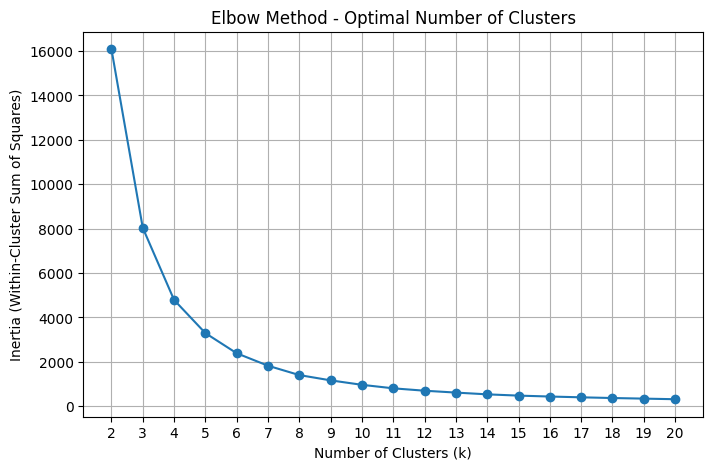

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method
inertias = []
k_values = range(2, 21)  # Try from 2 to 20 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(latent_features)
    inertias.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.xticks(k_values)
plt.title("Elbow Method - Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Silhouette Score (using latent features and predicted clusters)
sil_score = silhouette_score(latent_features, cluster_labels)
db_score = davies_bouldin_score(latent_features, cluster_labels)

print(f"\n📊 Silhouette Score: {sil_score:.4f}  (Higher is better, max 1)")
print(f"📉 Davies–Bouldin Index: {db_score:.4f}  (Lower is better)")


📊 Silhouette Score: 0.4945  (Higher is better, max 1)
📉 Davies–Bouldin Index: 0.5610  (Lower is better)


PCA was used to reduce the latent features to two dimensions for visualization. Posts were grouped by their K-Means cluster IDs, and the distribution of MBTI types within each cluster was analyzed. The 2D scatter plot revealed meaningful groupings, showing how SMOTE, autoencoder embeddings, and K-Means together captured structure in writing styles across personality types.


🧠 Cluster Breakdown (with SMOTE balancing):

Cluster 0 (4067 samples):
ESFJ    338
ESTJ    302
ENTP    300
ISTJ    268
ENFJ    263
ESTP    255
INTJ    250
ISTP    246
ENTJ    245
ENFP    245
INFP    240
INFJ    238
ISFJ    229
ISFP    227
INTP    224
ESFP    197
Name: count, dtype: int64

Cluster 1 (355 samples):
ISFP    72
ISTP    27
INTJ    27
ISFJ    27
ISTJ    24
ENFJ    24
ESFP    22
INTP    21
ENFP    21
INFP    20
ESTP    17
INFJ    15
ENTP    14
ESTJ    12
ESFJ     9
ENTJ     3
Name: count, dtype: int64

Cluster 2 (1667 samples):
ESFP    222
ESTJ    175
ENFP    119
ESTP    118
ISTP    103
ENFJ    100
ESFJ    100
INTJ     95
ENTP     93
ISFP     93
ISTJ     85
INTP     84
INFJ     83
INFP     72
ENTJ     63
ISFJ     62
Name: count, dtype: int64

Cluster 3 (2029 samples):
ESFP    189
ISTJ    168
ENTJ    160
ESTP    154
ESTJ    137
ENFP    127
ISTP    122
ISFP    120
ISFJ    119
ENTP    119
ESFJ    112
ENFJ    109
INFP    105
INTP     98
INTJ     97
INFJ     93
Name: count, dtype

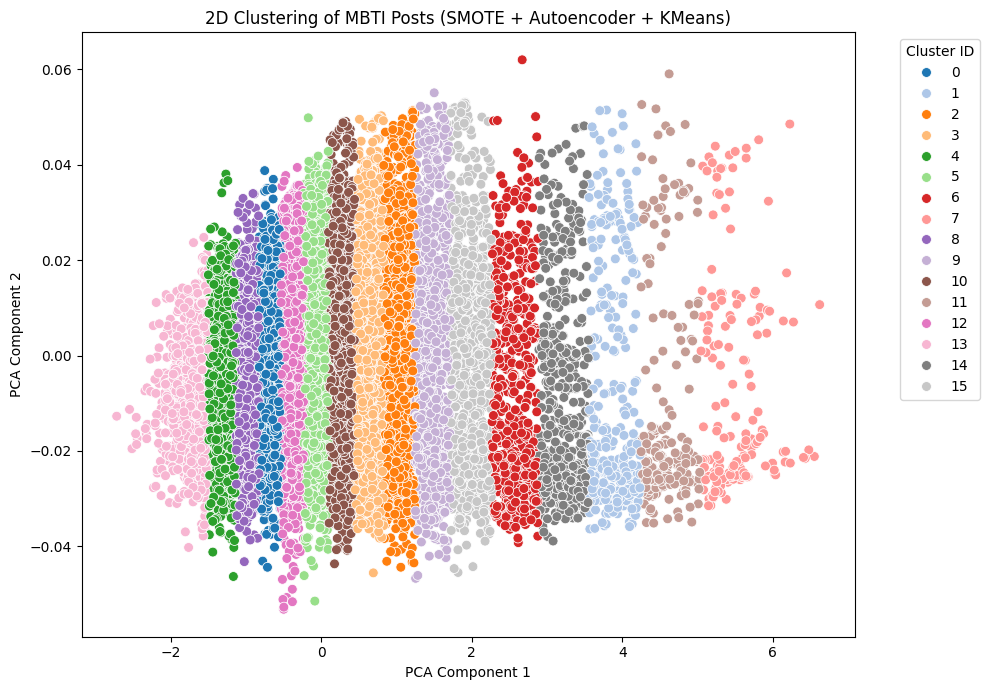

In [ ]:
from collections import defaultdict

# 2D PCA for scatter plot
pca_2d = PCA(n_components=2)
latent_2d = pca_2d.fit_transform(latent_features)

# Group MBTI types by cluster ID
cluster_to_types = defaultdict(list)
for idx, cluster_id in enumerate(cluster_labels):
    cluster_to_types[cluster_id].append(mbti_types[idx])

# Print cluster summaries
print("\n🧠 Cluster Breakdown (with SMOTE balancing):")
for cluster_id in range(n_clusters):
    types = cluster_to_types[cluster_id]
    summary = pd.Series(types).value_counts()
    print(f"\nCluster {cluster_id} ({len(types)} samples):")
    print(summary)

# Visualize with Seaborn (2D)
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x=latent_2d[:, 0],
    y=latent_2d[:, 1],
    hue=cluster_labels,
    palette='tab20',
    s=50,
    legend='full'
)
plt.title("2D Clustering of MBTI Posts (SMOTE + Autoencoder + KMeans)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Show legend
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, labels, title="Cluster ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


The unsupervised clustering grouped users based only on how they write, without using their personality labels. Across most clusters, types like INFP, INFJ, INTP, and INTJ appeared frequently. This makes sense because these types often write long, thoughtful, and introspective posts, which the model picked up on.

Types like ESFJ, ESTJ, and ESFP appeared much less often. These types are usually less active on text-heavy platforms or write in a more straightforward way, so the model couldn't strongly group them.

Since the model doesn’t know what MBTI is, it simply grouped users who write in similar styles. That’s why each cluster has a mix of personality types, but some types show up more depending on how distinct their writing patterns are.